In [54]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


# df
df = pd.read_csv("ZIONO_weekly_return_detailed.csv")
df.head(22)

df_21 = df[["Adj Close",  "Year"]]
df_21 = df_21[df_21.Year == 2021]

df_22 = df[["Adj Close", "Year"]]
df_22 = df_22[df_22.Year == 2022]


df.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Date,Week_Number,Year,Day,Weekday,mean_return,volatility
0,27.049999,27.049999,26.809999,26.860001,23.805077,8400,0.000,2020-12-24,51,2020,24,Thursday,0.00000,0.000000
1,26.870001,27.010000,26.799999,26.950001,23.884840,4800,0.335,2020-12-28,52,2020,28,Monday,0.13025,0.269162
2,26.950001,27.010000,26.760000,26.900000,23.840525,4500,-0.186,2020-12-29,52,2020,29,Tuesday,0.13025,0.269162
3,26.900000,27.100000,26.760000,26.900000,23.840525,8700,0.000,2020-12-30,52,2020,30,Wednesday,0.13025,0.269162
4,26.969999,27.000000,26.799999,27.000000,23.929153,11700,0.372,2020-12-31,52,2020,31,Thursday,0.13025,0.269162


In [55]:
# devide days into x and y
def get_x_y(df_21_days, W):
    in_df = df_21_days.copy()
    for i in range(W):  # index--0开始，
        real_i = i + 1
        in_df[f"minus_{real_i}"] = in_df["Adj Close"].shift(real_i)

    in_df = in_df.iloc[W: , :]

    x = in_df.iloc[:, 2:]
    y = in_df.iloc[:, 0]
    return x, y

# according to previous day and predict day to get label
def extract_label(x):
#     print(x)
#     print(x.shape)
    if x["pred"] > x["minus_1"]:
        return "green"
    elif x["pred"] < x["minus_1"]:
        return "red"
    else:
        return np.nan
    
    

"""
according to predict price list and previous day price list to calculate profit
return  
1. avg profit
2. short transactions
3. long  transactions
4. short avg profit
5. long  avg profit
6. short avg transaction days
7. long  avg transaction days
"""

def cal_profit(pred_s, act_s):
    pred = pred_s.values.tolist()
    actual = act_s.values.tolist()
    short_share = 0
    long_share = 0

    num_short = 0
    num_long = 0
    long_pro = 0
    short_pro = 0
    duration_long = 0
    duration_short = 0
    
    
    buyin_price = actual[0]
    buyin_day = 0
    for i in range(len(actual)):
        image_price = pred[i]
        act_price = actual[i]
        if image_price > act_price:
            if short_share == 0 and long_share == 0:
                long_share = 100 / act_price
                buyin_price = act_price
                buyin_day = i
            elif short_share > 0:
                short_pro += short_share * (buyin_price - act_price)
                num_short += 1
                duration_short += (i - buyin_day)
                
                short_share = 0
            else:
                pass

        elif image_price < act_price:
            if short_share == 0 and long_share == 0:
                short_share = 100 / act_price 
                buyin_price = act_price
                buyin_day = i
            elif long_share > 0:
                long_pro += long_share * ( act_price - buyin_price)
                num_long += 1
                duration_long += (i - buyin_day)                
                
                long_share = 0
            else:
                pass
#                 print("short share hold")
        else:
            pass
#             print("price equal")
                
    
    return (short_pro + long_pro) / (num_short + num_long)  , num_short, num_long, short_pro / num_short, long_pro/num_long, duration_short/num_short, duration_long/num_long


In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix
     
      
profit = {}
for w in range(5, 31): # 31
    x, y = get_x_y(df_21, w)

    # train logistic regression classifier on year 1 data
    lr = LinearRegression()
    lr.fit(x, y)

    # predict using x
    y_pred = lr.predict(x)

    # -1(pW)  -3 -4 -5,  y, y_pred(P* w+1)
    pred_df = pd.concat([x, y], axis = 1)
    pred_df["pred"] = y_pred
#     print( cal_profit(pred_df["pred"], pred_df["minus_1"]))
    profit_avg, short_num, long_num, short_profit, long_profit, short_days, long_days  = cal_profit(pred_df["pred"], pred_df["minus_1"])
    print(f"w={w} profit={profit_avg} short_tranctions={short_num}, long_tranctions={long_num} \n short_avg_profit={short_profit} long_avg_profit={long_profit}")
    print(f"short_avg_days={short_days} long_avg_days={long_days}")
    print("===========================")
    profit[w]= profit_avg    
    
    
profit   
    

w=5 profit=0.3630992235330705 short_tranctions=23, long_tranctions=24 
 short_avg_profit=0.11357453610484373 long_avg_profit=0.6022270489851211
short_avg_days=3.9130434782608696 long_avg_days=4.583333333333333
w=6 profit=0.3099112001960012 short_tranctions=25, long_tranctions=24 
 short_avg_profit=0.14617695875537723 long_avg_profit=0.4804677016966512
short_avg_days=3.64 long_avg_days=4.416666666666667
w=7 profit=0.38305675388920896 short_tranctions=21, long_tranctions=26 
 short_avg_profit=0.07180950277483039 long_avg_profit=0.6344487644046685
short_avg_days=4.190476190476191 long_avg_days=4.230769230769231
w=8 profit=0.30964590025864885 short_tranctions=24, long_tranctions=30 
 short_avg_profit=0.10451245960185183 long_avg_profit=0.47375265278408646
short_avg_days=3.375 long_avg_days=3.6
w=9 profit=0.6468971000934565 short_tranctions=19, long_tranctions=38 
 short_avg_profit=0.7175836473632021 long_avg_profit=0.6115538264585837
short_avg_days=4.052631578947368 long_avg_days=2.8157894

{5: 0.3630992235330705,
 6: 0.3099112001960012,
 7: 0.38305675388920896,
 8: 0.30964590025864885,
 9: 0.6468971000934565,
 10: 0.6204229447387927,
 11: 0.7163526394986581,
 12: 0.4503692374435277,
 13: 0.2955162399003194,
 14: 0.47314769207333884,
 15: 0.6201816678521909,
 16: 0.5377745682800251,
 17: 0.4534407003447433,
 18: 0.5405601213319009,
 19: 0.5038050742949134,
 20: 0.5505122471969972,
 21: 0.483353872375192,
 22: 0.5173347836198913,
 23: 0.5515829777010457,
 24: 0.504045903711596,
 25: 0.5069224765386449,
 26: 0.4493038274751719,
 27: 0.49254992763005095,
 28: 0.4595996243595618,
 29: 0.5039658069612227,
 30: 0.5793511489351052}

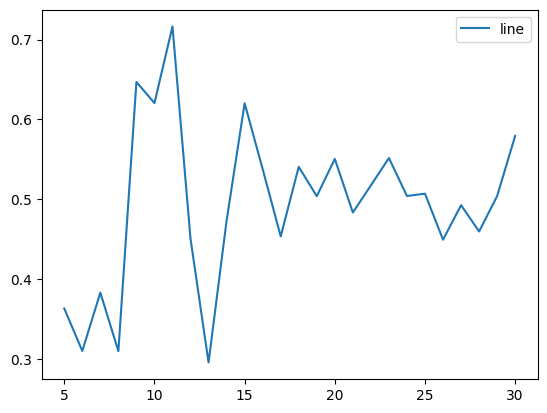

In [57]:
import seaborn as sns

leaner = pd.Series(profit)
profit_df = pd.DataFrame({"line": leaner})

profit_df.plot()
plt.show()

In [58]:
profit_df.line.idxmax()

11

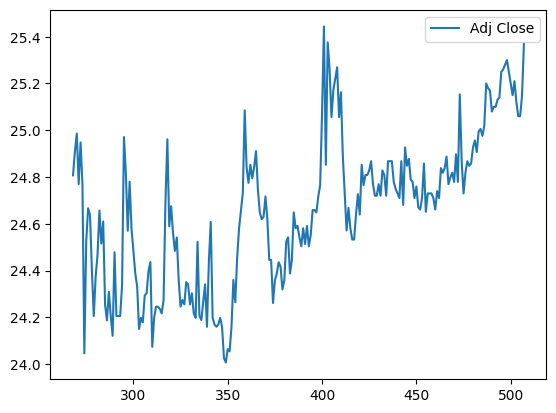

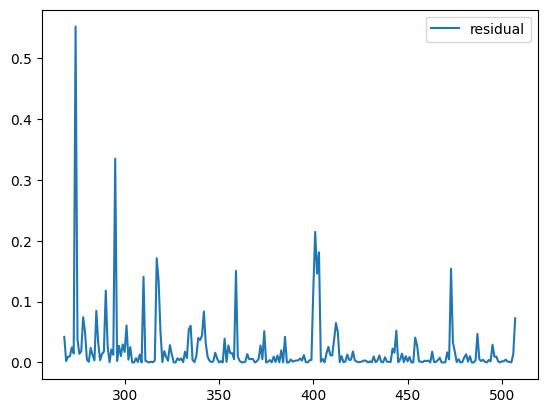

0.020976845059232793

In [59]:
# 2
profit = {}

w = 11
x, y = get_x_y(df_22, w)

# train logistic regression classifier on year 1 data
lr = LinearRegression()
lr.fit(x, y)

y_pred = lr.predict(x)

pred_df = pd.concat([x, y], axis = 1)
pred_df["pred"] = y_pred
pred_df["residual"] = pred_df["pred"] - pred_df["Adj Close"]
pred_df["residual"] = pred_df["residual"] * pred_df["residual"]

pred_df[[ "Adj Close"]].plot()
pred_df[["residual"]].plot()
plt.show()

rse_avg = pred_df["residual"].mean()
rse_avg
    

In [60]:
# 3
w = 11
x, y = get_x_y(df_22, w)

# train logistic regression classifier on year 1 data
lr = LinearRegression()
lr.fit(x, y)

# make predictions for year 2 data
y_pred = lr.predict(x)

# -1(pW)  -3 -4 -5,  y, y_pred(P* w+1)
pred_df = pd.concat([x, y], axis = 1)
pred_df["pred"] = y_pred
#     print(pred_df)
profit_avg2, short_num2, long_num2, short_profit2, long_profit2, short_days2, long_days2  = cal_profit(pred_df["pred"], pred_df["minus_1"])
print(f"w={w} profit={profit_avg2} short_tranctions={short_num2}, long_tranctions={long_num2} \n short_avg_profit={short_profit2} long_avg_profit={long_profit2}")
print(f"short_avg_days={short_days2} long_avg_days={long_days2}")
print("===========================")
    

w=11 profit=0.4216447203592678 short_tranctions=25, long_tranctions=42 
 short_avg_profit=0.4800732390573455 long_avg_profit=0.3868658401818406
short_avg_days=2.24 long_avg_days=2.238095238095238


In [61]:
# 3
f"22 short_tranctions={short_num2}, long_tranctions={long_num2}"

'22 short_tranctions=25, long_tranctions=42'

In [62]:
# 4
f"22 short_avg={short_profit2}, long_avg={long_profit2}"

'22 short_avg=0.4800732390573455, long_avg=0.3868658401818406'

In [63]:
# 5
f"22 short_avg_days={short_days2} long_avg_days={long_days2}"

'22 short_avg_days=2.24 long_avg_days=2.238095238095238'

In [66]:
# 6  copy 2021 result here to compare
"2021 w=11 profit=0.7163526394986581 short_tranctions=23, long_tranctions=25 short_avg_profit=0.7522354196962379 long_avg_profit=0.6833404817168848short_avg_days=4.130434782608695 long_avg_days=3.84"

'2021 w=11 profit=0.7163526394986581 short_tranctions=23, long_tranctions=25 short_avg_profit=0.7522354196962379 long_avg_profit=0.6833404817168848short_avg_days=4.130434782608695 long_avg_days=3.84'

In [67]:
"2022 w=11 profit=0.4216447203592678 short_tranctions=25, long_tranctions=42  short_avg_profit=0.4800732390573455 long_avg_profit=0.3868658401818406short_avg_days=2.24 long_avg_days=2.238095238095238"

'2022 w=11 profit=0.4216447203592678 short_tranctions=25, long_tranctions=42  short_avg_profit=0.4800732390573455 long_avg_profit=0.3868658401818406short_avg_days=2.24 long_avg_days=2.238095238095238'